# Preprocessing UPenn GBM dataset
The goal of this file is to create tfrecord files of the UPenn GBM dataset, that can be used for training

Link to download: https://www.cancerimagingarchive.net/collection/upenn-gbm/

Infos about the dataset:
- the dataset contains "only" de novo Glioblastoma (GBM) patients from the University of Pennsylvania Health System
- age and sex are technically included, so is other information, but I don't think I'll be needing it

The dataset structure looks like this:
```
path_to_upenn_gbm_dataset_folder
│
│__automated_segm
    │
    │__UPENN-GBM-00001_11_automated_approx_segm.nii.gz
    │__UPENN-GBM-00002_11_automated_approx_segm.nii.gz
    │__UPENN-GBM-00003_11_automated_approx_segm.nii.gz
    ...
│
│__images_segm
    │
    │__UPENN-GBM-00002_11_segm.nii.gz
    │__UPENN-GBM-00006_11_segm.nii.gz
    │__UPENN-GBM-00008_11_segm.nii.gz
    ...
│
│__images_structural
    │
    │__UPENN-GBM-00001_11
        │
        │__UPENN-GBM-00001_11_FLAIR.nii.gz
        │__UPENN-GBM-00001_11_T1.nii.gz
        │__UPENN-GBM-00001_11_T1GD.nii.gz
        │__UPENN-GBM-00001_11_T2.nii.gz
    │...
│
│__...
```

In [5]:
# TO-DO:
# [X] Get overview of dataset
# [X] Rotate images 90 degress and percentile normalize them
# [X] Create png images of the largest visible tumor slice in each scan
# [X] Combine the four sequences and the segmentation mask into a single tfrecord file
# [ ] Profit?

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from pathlib import Path
import random
import nibabel as nib

In [11]:
path_to_upenn_gbm_dataset_folder = '/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/UPenn_GBM/PKG - UPENN-GBM-NIfTI/UPENN-GBM/NIfTI-files'
path_to_upenn_data_availability = '/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/UPenn_GBM/UPENN-GBM_data_availability.csv'
path_to_upenn_clinical_data = '/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/UPenn_GBM/UPENN-GBM_clinical_info_v2.1.csv'
path_to_upenn_png_slices = '/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/UPenn_GBM/upenn_gbm_slices'
path_to_upenn_tfrs = Path('/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/UPenn_GBM/upenn_gbm_tfrs')

path_to_upenn_rgb_tfrs = path_to_upenn_tfrs / 'rgb_tfrs'
path_to_upenn_gray_tfrs = path_to_upenn_tfrs / 'gray_tfrs'

In [3]:
# create custom class for each patient to store all relevant information

class Patient:
    def __init__(self, id):
        self.id = id

        self.t1 = None # Path to T1 image
        self.t1c = None # Path to T1c image
        self.t2 = None # Path to T2 image
        self.flair = None # Path to FLAIR image

        self.tumor_segmentation = None # Path to tumor segmentation mask

## Get Overview of Dataset

In [4]:
# read .csv file
data_availability = pd.read_csv(path_to_upenn_data_availability)
data_availability

,ID,Structural imaging,DTI imaging,DSC imaging,Automatic Tumor Segmentation,Corrected Tumor Segmentation,Gender,Age,Overall Survival,IDH1,MGMT,KPS,Extent of Resection,Associated Baseline Scan,Associated Recurrence Scan,PsP_TP score,CaPTk Radiomic Features
0,UPENN-GBM-00001_11,available,available,available,available,available,available,available,not available,available,not available,not available,available,-,not available,not available,available
1,UPENN-GBM-00002_11,available,available,available,available,available,available,available,available,available,not available,not available,available,-,not available,not available,available
2,UPENN-GBM-00003_11,available,available,available,available,available,available,available,not available,available,not available,not available,available,-,not available,not available,available
3,UPENN-GBM-00004_11,available,available,available,available,available,available,available,not available,not available,not available,not available,available,-,not available,not available,available
4,UPENN-GBM-00005_11,available,available,available,available,available,available,available,not available,available,not available,not available,available,-,not available,not available,available
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
666,UPENN-GBM-00626_21,available,available,available,not available,not available,available,available,not available,available,available,not available,not available,not available,-,available,not available
667,UPENN-GBM-00627_21,available,available,available,not available,not available,available,available,not available,available,not available,not available,not available,not available,-,available,not available
668,UPENN-GBM-00628_21,available,available,available,not available,not available,available,available,not available,available,not available,not available,not available,not available,-,available,not available
669,UPENN-GBM-00629_21,available,available,available,not available,not available,available,available,not available,available,available,not available,not available,not available,-,available,not available


In [8]:
clinical_data = pd.read_csv(path_to_upenn_clinical_data)
clinical_data

,ID,Gender,Age_at_scan_years,Survival_from_surgery_days_UPDATED,Survival_Status,Survival_Censor,IDH1,MGMT,KPS,GTR_over90percent,Time_since_baseline_preop,PsP_TP_score
0,UPENN-GBM-00001_11,F,52.16,960,Deceased,Not Available,Wildtype,Not Available,Not Available,Y,0,NaN
1,UPENN-GBM-00002_11,F,61.30,291,Deceased,Not Available,Wildtype,Not Available,Not Available,Y,0,NaN
2,UPENN-GBM-00003_11,M,42.82,2838,Deceased,Not Available,Wildtype,Not Available,Not Available,Y,0,NaN
3,UPENN-GBM-00004_11,M,33.43,623,Deceased,Not Available,NOS/NEC,Not Available,Not Available,Y,0,NaN
4,UPENN-GBM-00005_11,M,53.33,1143,Deceased,Not Available,Wildtype,Not Available,Not Available,Y,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
666,UPENN-GBM-00626_21,F,57.19,288,Deceased,Not Available,Wildtype,Unmethylated,Not Available,Not Applicable,234,5.0
667,UPENN-GBM-00627_21,F,57.40,365,Deceased,Not Available,Wildtype,Not Available,Not Available,Not Applicable,Not Available,4.0
668,UPENN-GBM-00628_21,M,55.09,79,Deceased,Not Available,Wildtype,Not Available,Not Available,Not Applicable,Not Available,6.0
669,UPENN-GBM-00629_21,M,71.44,66,Deceased,Not Available,Wildtype,Unmethylated,Not Available,Not Applicable,Not Available,6.0


In [10]:
# get all IDs of scans where "Automatic Tumor Segmentation" is available
ids_with_automatic_tumor_segmentation = data_availability[data_availability['Automatic Tumor Segmentation'] == 'available']['ID']
ids_with_corrected_tumor_segmnetation = data_availability[data_availability['Corrected Tumor Segmentation'] == 'available']['ID']

# remove ids with corrected tumor segmentation from ids with automatic tumor segmentation
ids_with_automatic_tumor_segmentation = ids_with_automatic_tumor_segmentation[~ids_with_automatic_tumor_segmentation.isin(ids_with_corrected_tumor_segmnetation)]

In [11]:
print(len(ids_with_automatic_tumor_segmentation))
print(len(ids_with_corrected_tumor_segmnetation))

379
232


In [10]:
# get all patients where the IDH1 mutation status is not mutated
# WHO says glioblastoma needs to have IDH wildtype status

# different values of IDH1 Mutation Status
print(clinical_data['IDH1'].unique())

ids_with_wildtype_idh1 = clinical_data[clinical_data['IDH1'] == 'Wildtype']['ID']
print(len(ids_with_wildtype_idh1))

['Wildtype' 'NOS/NEC' 'Mutated']
546


get nifti and segmentation files for the ids

In [12]:
all_patients = []
patients_with_missing_data = []

# loop through autmatic tumor segmentation ids
# get four regular sequences
# get tumor segmentation mask
for id in tqdm(ids_with_automatic_tumor_segmentation):
    patient = Patient(id = id)
    path_to_t1 = Path(path_to_upenn_gbm_dataset_folder) / 'images_structural' / f'{id}' / f'{id}_T1.nii.gz'
    path_to_t1c = Path(path_to_upenn_gbm_dataset_folder) / 'images_structural' / f'{id}' / f'{id}_T1GD.nii.gz'
    path_to_t2 = Path(path_to_upenn_gbm_dataset_folder) / 'images_structural' / f'{id}' / f'{id}_T2.nii.gz'
    path_to_flair = Path(path_to_upenn_gbm_dataset_folder) / 'images_structural' / f'{id}' / f'{id}_FLAIR.nii.gz'
    path_to_automatic_segmentation = Path(path_to_upenn_gbm_dataset_folder) / 'automated_segm' / f'{id}_automated_approx_segm.nii.gz'

    if path_to_t1.is_file():
        patient.t1 = path_to_t1
    else:
        patients_with_missing_data.append(id)
        print(f'No T1 image for patient {id}')
    
    if path_to_t1c.is_file():
        patient.t1c = path_to_t1c
    else:
        patients_with_missing_data.append(id)
        print(f'No T1c image for patient {id}')

    if path_to_t2.is_file():
        patient.t2 = path_to_t2
    else:
        patients_with_missing_data.append(id)
        print(f'No T2 image for patient {id}')
    
    if path_to_flair.is_file():
        patient.flair = path_to_flair
    else:
        patients_with_missing_data.append(id)
        print(f'No FLAIR image for patient {id}')
    
    if path_to_automatic_segmentation.is_file():
        patient.tumor_segmentation = path_to_automatic_segmentation
    else:
        patients_with_missing_data.append(id)
        print(f'No tumor segmentation mask for patient {id}')

    all_patients.append(patient)


# loop through corrected tumor segmentation ids
# get four regular sequences
# get tumor segmentation mask
for id in tqdm(ids_with_corrected_tumor_segmnetation):
    patient = Patient(id = id)
    path_to_t1 = Path(path_to_upenn_gbm_dataset_folder) / 'images_structural' / f'{id}' / f'{id}_T1.nii.gz'
    path_to_t1c = Path(path_to_upenn_gbm_dataset_folder) / 'images_structural' / f'{id}' / f'{id}_T1GD.nii.gz'
    path_to_t2 = Path(path_to_upenn_gbm_dataset_folder) / 'images_structural' / f'{id}' / f'{id}_T2.nii.gz'
    path_to_flair = Path(path_to_upenn_gbm_dataset_folder) / 'images_structural' / f'{id}' / f'{id}_FLAIR.nii.gz'
    path_to_manual_segmentation = Path(path_to_upenn_gbm_dataset_folder) / 'images_segm' / f'{id}_segm.nii.gz'

    if path_to_t1.is_file():
        patient.t1 = path_to_t1
    else:
        patients_with_missing_data.append(id)
        print(f'No T1 image for patient {id}')
    
    if path_to_t1c.is_file():
        patient.t1c = path_to_t1c
    else:
        patients_with_missing_data.append(id)
        print(f'No T1c image for patient {id}')

    if path_to_t2.is_file():
        patient.t2 = path_to_t2
    else:
        patients_with_missing_data.append(id)
        print(f'No T2 image for patient {id}')
    
    if path_to_flair.is_file():
        patient.flair = path_to_flair
    else:
        patients_with_missing_data.append(id)
        print(f'No FLAIR image for patient {id}')
    
    if path_to_manual_segmentation.is_file():
        patient.tumor_segmentation = path_to_manual_segmentation
    else:
        patients_with_missing_data.append(id)
        print(f'No tumor segmentation mask for patient {id}')
        
    all_patients.append(patient)

100%|██████████| 232/232 [00:00<00:00, 10733.39it/s]

No tumor segmentation mask for patient UPENN-GBM-00001_11
No tumor segmentation mask for patient UPENN-GBM-00003_11
No tumor segmentation mask for patient UPENN-GBM-00004_11
No tumor segmentation mask for patient UPENN-GBM-00005_11
No tumor segmentation mask for patient UPENN-GBM-00007_11
No tumor segmentation mask for patient UPENN-GBM-00010_11
No tumor segmentation mask for patient UPENN-GBM-00015_11
No tumor segmentation mask for patient UPENN-GBM-00019_11
No tumor segmentation mask for patient UPENN-GBM-00024_11
No tumor segmentation mask for patient UPENN-GBM-00025_11
No tumor segmentation mask for patient UPENN-GBM-00027_11
No tumor segmentation mask for patient UPENN-GBM-00028_11
No tumor segmentation mask for patient UPENN-GBM-00032_11
No tumor segmentation mask for patient UPENN-GBM-00036_11
No tumor segmentation mask for patient UPENN-GBM-00037_11
No tumor segmentation mask for patient UPENN-GBM-00039_11
No tumor segmentation mask for patient UPENN-GBM-00042_11
No tumor segme

In [13]:
print(f"# of all patients: {len(all_patients)}")
print(f"# of patients with missing data: {len(patients_with_missing_data)}")

# of all patients: 611
# of patients with missing data: 85


because manual segmentation would take too long in my case, I'll just dismiss the 85 patients with missing segmentation files, more than 500 is already not too bad

In [14]:
# remove patients with missing data
all_patients = [patient for patient in all_patients if patient.id not in patients_with_missing_data]

print(f"# of all patients after removing patients with missing data: {len(all_patients)}")

# of all patients after removing patients with missing data: 526


Display 9 random images from all patients including the segmentations

In [15]:
def visualize_random_patients(all_patients):

    # Funktion zum Laden und Anzeigen eines NIfTI-Bildes
    def load_nifti_image(path):
        return nib.load(str(path)).get_fdata()

    # 9 zufällige Patienten auswählen
    random_patients = random.sample(all_patients, 9)

    # 3x3 Grafik erstellen
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))

    for i, patient in enumerate(random_patients):
        ax = axes[i // 3, i % 3]
        
        # Zufällige MRT Sequenz auswählen
        sequences = [patient.t1, patient.t1c, patient.t2, patient.flair]
        sequence_path = random.choice([seq for seq in sequences if seq is not None])
        
        # MRT Bild laden
        image = load_nifti_image(sequence_path)
        
        # Segmentierung laden
        segmentation = load_nifti_image(patient.tumor_segmentation)
        
        # Größte sichtbare Tumorschicht finden
        slice_index = np.argmax(np.sum(segmentation, axis=(0, 1)))
        
        # MRT Bild anzeigen
        ax.imshow(image[:, :, slice_index], cmap = 'gray')
        
        # Segmentierung farblich darüber legen
        ax.imshow(segmentation[:, :, slice_index], cmap='Reds', alpha=0.5)
        
        ax.axis('off')

        # Title
        max_value = np.max(image)
        mean_value = np.mean(image)
        min_value = np.min(image)

        title = (
            f'Patient {patient.id}\n'
            f'Sequence: {sequence_path.name}\n'
            f'Max: {max_value:.2f}, Mean: {mean_value:.2f}, Min: {min_value:.2f}\n'
            f'Shape: {image.shape}'
        )

        ax.set_title(f'{title}')

    plt.tight_layout()
    plt.show()

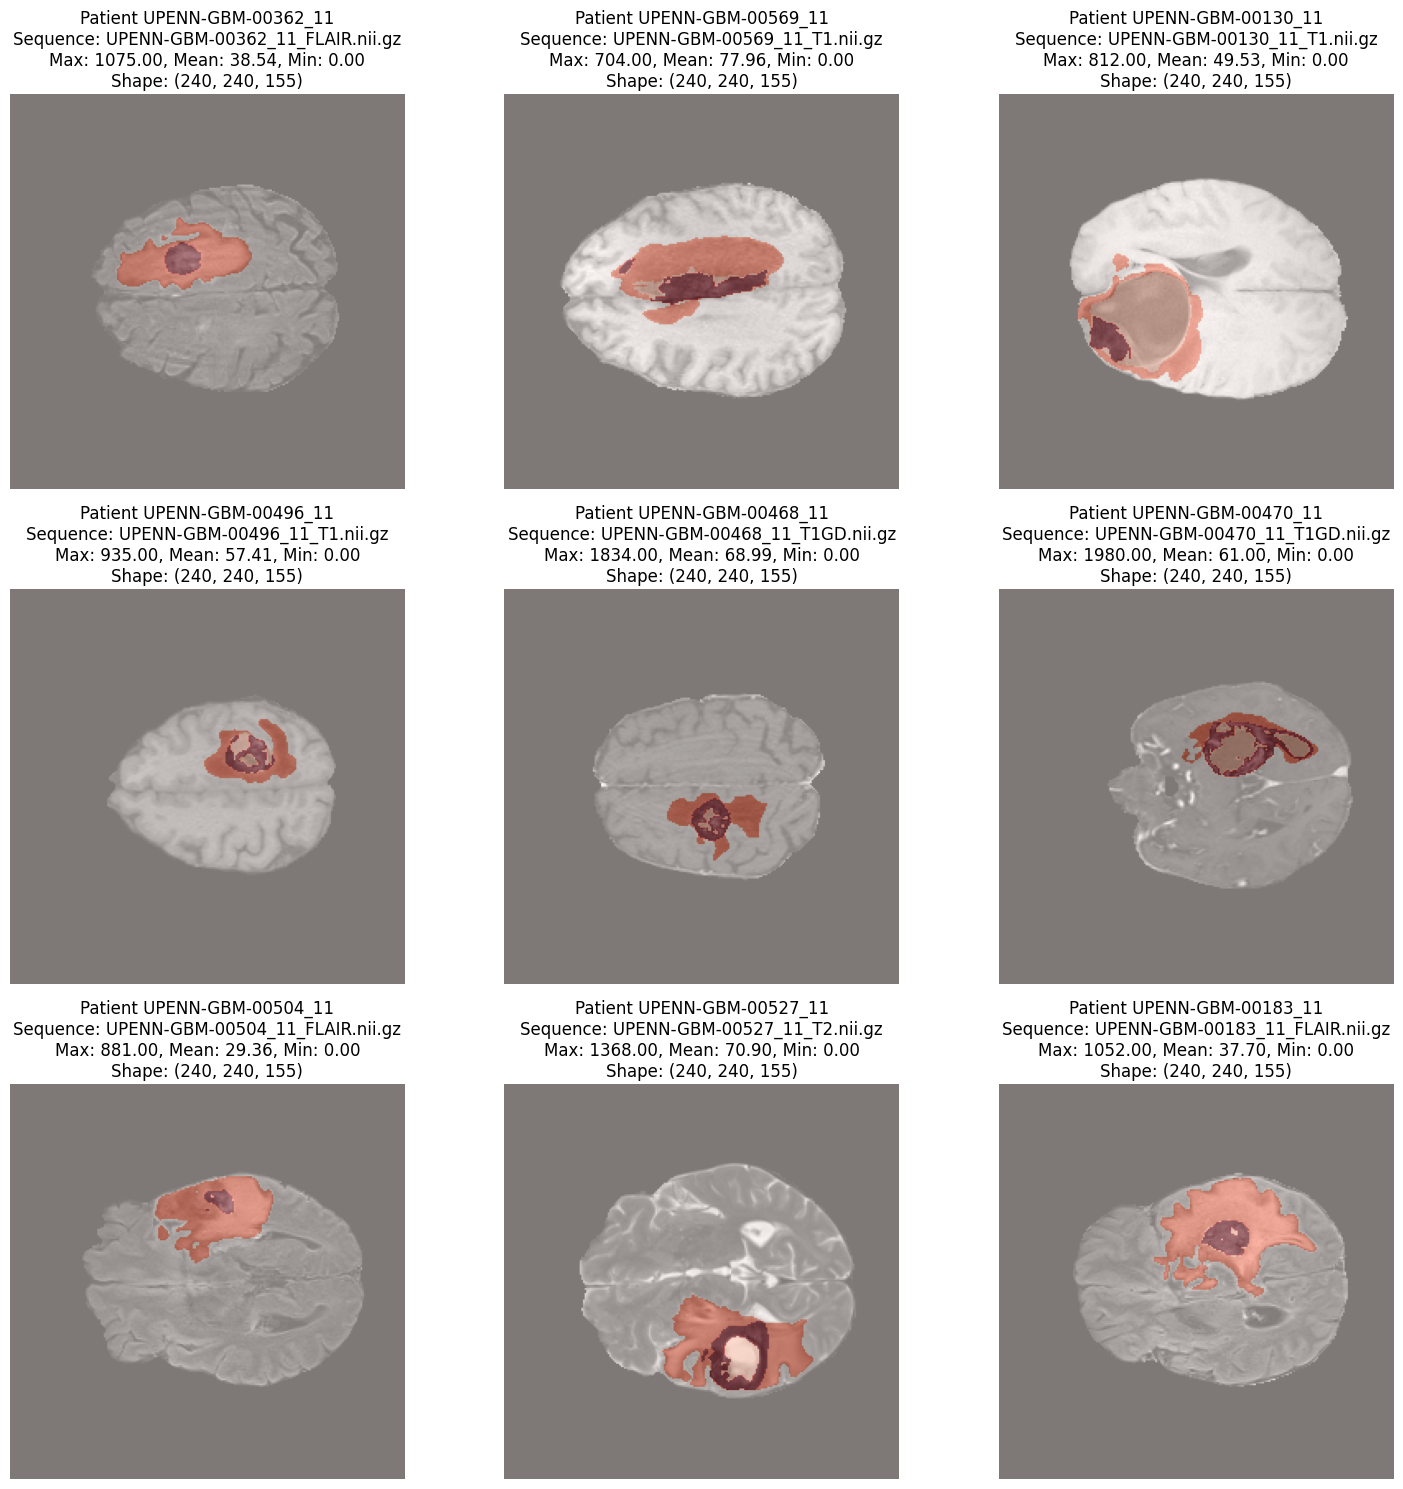

In [16]:
visualize_random_patients(all_patients)

## Image Rotation and Normalization

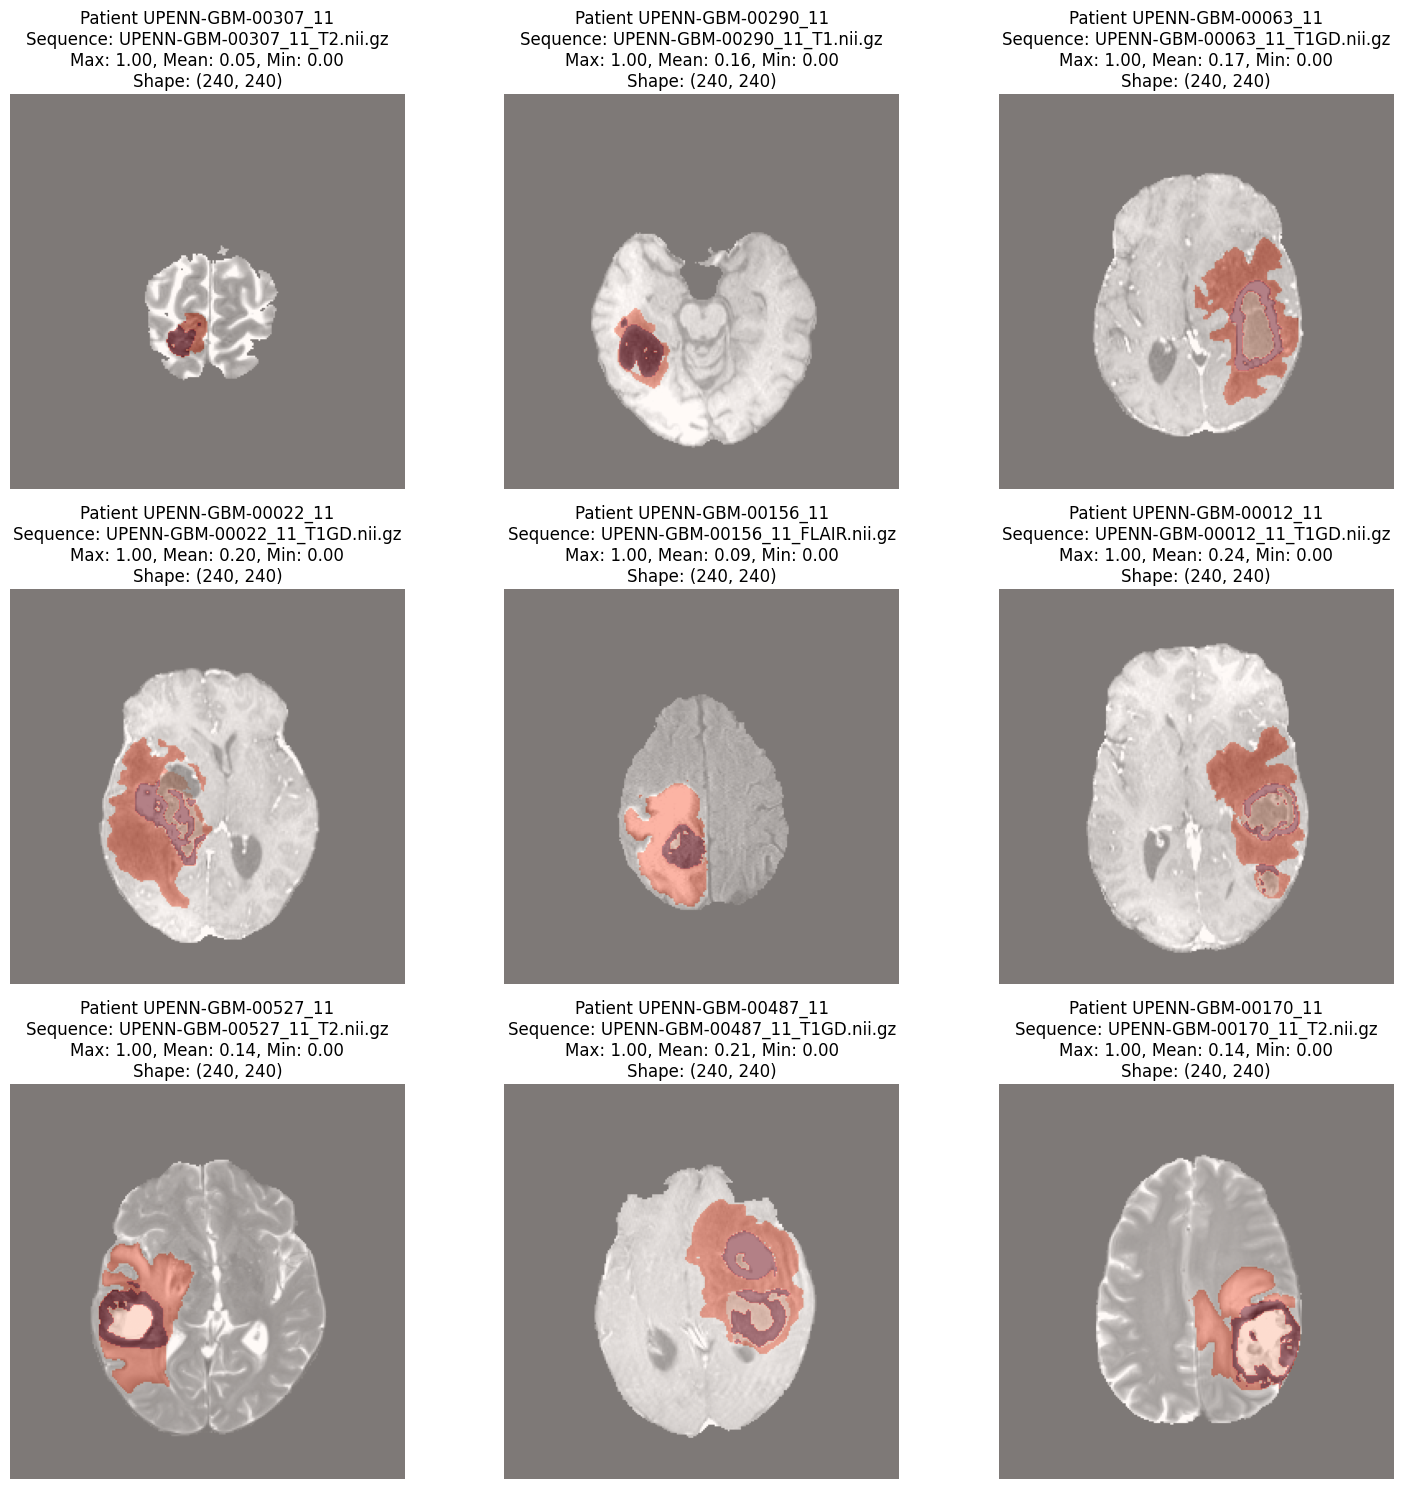

In [17]:
def rotate_and_normalize(image):
    # Rotate the image 90 degrees
    rotated_image = np.rot90(image, k=-1)
    
    # Percentile normalization
    lower_percentile = np.percentile(rotated_image, 1)
    upper_percentile = np.percentile(rotated_image, 99)
    normalized_image = np.clip(rotated_image, lower_percentile, upper_percentile)
    normalized_image = (normalized_image - lower_percentile) / (upper_percentile - lower_percentile)
    
    return normalized_image

def visualize_random_patients_rotated_normalized(all_patients):
    def load_nifti_image(path):
        return nib.load(str(path)).get_fdata()

    random_patients = random.sample(all_patients, 9)
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))

    for i, patient in enumerate(random_patients):
        ax = axes[i // 3, i % 3]
        sequences = [patient.t1, patient.t1c, patient.t2, patient.flair]
        sequence_path = random.choice([seq for seq in sequences if seq is not None])
        image = load_nifti_image(sequence_path)
        segmentation = load_nifti_image(patient.tumor_segmentation)
        slice_index = np.argmax(np.sum(segmentation, axis=(0, 1)))
        
        # Rotate and normalize the image and segmentation
        image_rotated_normalized = rotate_and_normalize(image[:, :, slice_index])
        segmentation_rotated = np.rot90(segmentation[:, :, slice_index], k=-1)
        
        ax.imshow(image_rotated_normalized, cmap='gray', alpha = 1)
        ax.imshow(segmentation_rotated, cmap='Reds', alpha=0.5)
        ax.axis('off')

        max_value = np.max(image_rotated_normalized)
        mean_value = np.mean(image_rotated_normalized)
        min_value = np.min(image_rotated_normalized)

        title = (
            f'Patient {patient.id}\n'
            f'Sequence: {sequence_path.name}\n'
            f'Max: {max_value:.2f}, Mean: {mean_value:.2f}, Min: {min_value:.2f}\n'
            f'Shape: {image_rotated_normalized.shape}'
        )

        ax.set_title(f'{title}')

    plt.tight_layout()
    plt.show()

visualize_random_patients_rotated_normalized(all_patients)

## Save images with largest slice as png

In [18]:
def show_segmentation_classes(patient):
    def load_nifti_image(path):
        return nib.load(str(path)).get_fdata()

    segmentation = load_nifti_image(patient.tumor_segmentation)
    unique_classes = np.unique(segmentation)
    
    print(f"Unique segmentation classes for patient {patient.id}: {unique_classes}")

# Example usage for a random patient
random_patient = random.choice(all_patients)
show_segmentation_classes(random_patient)

Unique segmentation classes for patient UPENN-GBM-00040_11: [0. 1. 2. 4.]


I think the segmentations are classified like this:\
0 = normal\
1 = necrosis\
2 = edema\
4 = solid

I will focus on the solid parts, so 4

In [24]:
def save_largest_tumor_slice(patient, output_folder):
    def load_nifti_image(path):
        return nib.load(str(path)).get_fdata()

    # Load segmentation and find the slice with the largest area of segmentation class 4
    segmentation = load_nifti_image(patient.tumor_segmentation)
    slice_index = np.argmax(np.sum(segmentation == 4, axis=(0, 1)))

    # Create output directory for the patient
    patient_output_folder = Path(output_folder) / patient.id
    patient_output_folder.mkdir(parents=True, exist_ok=True)

    # Save each sequence and the segmentation mask as PNG
    sequences = {
        't1': patient.t1,
        't1c': patient.t1c,
        't2': patient.t2,
        'flair': patient.flair
    }

    for sequence_name, sequence_path in sequences.items():
        if sequence_path is not None:
            image = load_nifti_image(sequence_path)
            image_slice = image[:, :, slice_index]
            image_rotated_normalized = rotate_and_normalize(image_slice)
            plt.imsave(patient_output_folder / f'{patient.id}_{sequence_name}.png', image_rotated_normalized, cmap='gray')

    # Save the segmentation mask
    segmentation_slice = segmentation[:, :, slice_index]
    segmentation_mask = (segmentation_slice == 4).astype(np.uint8)  # Create a binary mask for class 4
    segmentation_rotated = np.rot90(segmentation_mask, k=-1)
    plt.imsave(patient_output_folder / f'{patient.id}_mask.png', segmentation_rotated, cmap='gray')

# Save largest tumor slice for all patients
for patient in tqdm(all_patients):
    save_largest_tumor_slice(patient, path_to_upenn_png_slices)

 14%|█▎        | 72/526 [00:10<01:05,  6.91it/s]/var/folders/by/b05bkcn50tb0fx4h3hhz0h800000gn/T/ipykernel_91784/3486549700.py:9: RuntimeWarning: invalid value encountered in divide
  normalized_image = (normalized_image - lower_percentile) / (upper_percentile - lower_percentile)
100%|██████████| 526/526 [01:14<00:00,  7.02it/s]


Check if each folder contains 5 png files

In [25]:
def check_png_files_in_folder(folder_path):
    # Get all subfolders in the main folder
    subfolders = [f.path for f in os.scandir(folder_path) if f.is_dir()]

    # Check each subfolder for the number of PNG files
    for subfolder in subfolders:
        png_files = [f for f in os.listdir(subfolder) if f.endswith('.png')]
        if len(png_files) != 5:
            print(f"Subfolder {subfolder} contains {len(png_files)} PNG files instead of 5.")

# Check the path_to_upenn_png_slices folder
check_png_files_in_folder(path_to_upenn_png_slices)

## Create TFRecord Files for patients

In [38]:
def serialize_example(image, label):
    """
    image: A NumPy array containing the image (could be shape (H, W, 5) or (H, W, 3, 5))
    label: Integer label (you can adapt this to your actual label)
    """
    # If 'image' is already a NumPy array, just flatten it:
    image_flattened = image.ravel()

    # Create a tf.train.Example
    tumor_example = tf.train.Example(
        features=tf.train.Features(
            feature={
                'image': tf.train.Feature(float_list=tf.train.FloatList(value=image_flattened)),
                'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[label]))
            }
        )
    )
    return tumor_example.SerializeToString()

def write_patient_to_tfrecord(
    patient_id,
    patient_folder,
    tfrecord_folder,
    label=0,
    is_rgb=False,
    compression_type="GZIP"
):
    """
    patient_id: Unique identifier for the patient (string or int).
    patient_folder: Path to the folder containing the 5 PNG images (T1, T1c, T2, Flair, mask).
    tfrecord_folder: Output folder for the TFRecord file.
    label: A label (int) for the example, can be adapted to your classification task.
    is_rgb: Whether to replicate each 2D slice into 3 channels. 
            - If False -> shape (H, W, 5)
            - If True  -> shape (H, W, 3, 5)
    """
    # Ensure output folder exists
    tfrecord_folder = Path(tfrecord_folder)
    tfrecord_folder.mkdir(parents=True, exist_ok=True)

    # Define the order of sequences you want to load
    sequence_names = ['t1', 't1c', 't2', 'flair', 'mask']

    # Gather all 5 images
    images = []
    for seq_name in sequence_names:
        png_path = Path(patient_folder) / f'{patient_id}_{seq_name}.png'
        if not png_path.exists():
            raise FileNotFoundError(f"Expected file {png_path} not found for patient {patient_id}")
        
        # Read in grayscale (single channel)
        # Resulting shape => (H, W)
        img = cv2.imread(str(png_path), cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise ValueError(f"cv2 could not read the file: {png_path}")

        # Convert to float32
        img = img.astype(np.float32)

        # If is_rgb=True, replicate the single channel to 3 channels
        # final shape => (H, W, 3)
        if is_rgb:
            img = np.stack([img, img, img], axis=-1)  # (H, W, 3)

        images.append(img)

    # Stack the 5 images along a new axis
    if is_rgb:
        # images is a list of 5 items, each (H, W, 3)
        # final shape => (H, W, 3, 5)
        final_image = np.stack(images, axis=-1)
    else:
        # images is a list of 5 items, each (H, W)
        # final shape => (H, W, 5)
        final_image = np.stack(images, axis=-1)

    # Write one example to a TFRecord
    tfrecord_filename = tfrecord_folder / f"{patient_id}.tfrecord"
    options = tf.io.TFRecordOptions(compression_type=compression_type)
    with tf.io.TFRecordWriter(str(tfrecord_filename), options=options) as writer:
        # Create a single Example for this patient
        example = serialize_example(final_image, label)
        writer.write(example)

    #print(f"Saved TFRecord for patient {patient_id} at {tfrecord_filename}")

def create_tfrecords_for_all_patients(
    png_root_folder,
    tfrecord_folder,
    labels_dict=None,
    is_rgb=False
):
    """
    Loop over all patients, read their 5 PNG slices, 
    and write one TFRecord file per patient.
    
    png_root_folder: The folder where each patient's subfolder is located.
                     Inside each subfolder there should be 5 PNG images.
    tfrecord_folder: Output folder for the TFRecord files.
    patient_ids: List or iterable of patient IDs (strings or ints).
    labels_dict: A dictionary mapping patient_id -> label. If None, default label=0.
    is_rgb: Whether to replicate each 2D slice into 3 channels. 
    """

    patient_ids = [
        f.name for f in Path(png_root_folder).iterdir()
        if f.is_dir()
    ]

    for pid in tqdm(patient_ids):
        patient_folder = Path(png_root_folder) / str(pid)
        
        # if a labels_dict is provided, fetch the label, else default to 0
        label = labels_dict[pid] if (labels_dict is not None and pid in labels_dict) else 0
        
        write_patient_to_tfrecord(
            patient_id=pid,
            patient_folder=patient_folder,
            tfrecord_folder=tfrecord_folder,
            label=label,
            is_rgb=is_rgb
        )


In [51]:
os.makedirs(path_to_upenn_rgb_tfrs, exist_ok=True)
os.makedirs(path_to_upenn_gray_tfrs, exist_ok=True)

# Create TFRecords in grayscale mode:
create_tfrecords_for_all_patients(
    png_root_folder=path_to_upenn_png_slices,
    tfrecord_folder=path_to_upenn_gray_tfrs,
    is_rgb=False
)

# Optionally create TFRecords in RGB mode:
create_tfrecords_for_all_patients(
    png_root_folder=path_to_upenn_png_slices,
    tfrecord_folder=path_to_upenn_rgb_tfrs,
    is_rgb=True
)

100%|██████████| 526/526 [01:13<00:00,  7.12it/s]


## Read TFRecord files

Label: 0
(240, 240, 5)


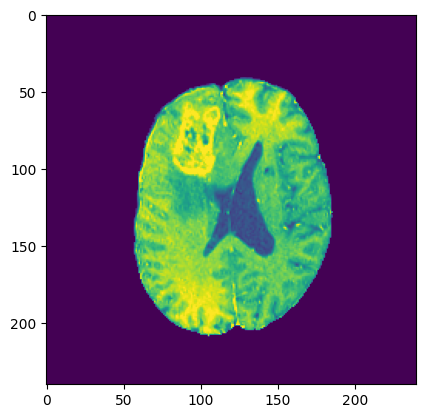

In [52]:
path_to_testing_tfr = "/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/UPenn_GBM/upenn_gbm_tfrs/gray_tfrs/UPENN-GBM-00014_11.tfrecord"
rgb = False

num_images = 5 # 4 sequences + 1 mask

image_shape = []

if rgb: # rgb images need three channels
    image_shape = [240, 240, 3, num_images]
else: # gray scale images don't
    image_shape = [240, 240, num_images]

feature_description = {
    "image": tf.io.FixedLenFeature(image_shape, tf.float32),
    "label": tf.io.FixedLenFeature([], tf.int64, default_value=0),
}

def parse(serialize_patient):
    example = tf.io.parse_single_example(serialize_patient, feature_description)

    image = example["image"]
    image = tf.reshape(image, image_shape) #[149, 185, 155, 4] = old size
    
    return image, example["label"]

dataset = tf.data.TFRecordDataset([path_to_testing_tfr], compression_type="GZIP")
parsed_dataset = dataset.map(parse)

test_image = parsed_dataset.take(1)
for image, label in test_image:
    print(f"Label: {label.numpy()}")
    numpy_image = image.numpy()
    print(numpy_image.shape)
    if rgb:
        plt.imshow(numpy_image[:,:,2,1])
    else:
        plt.imshow(numpy_image[:,:,1])

## Remove patients where the wildtype is either unknown or mutated

In [13]:
def remove_not_wildtype_idh1_tfrs(path_to_folder):

    # Read the clinical data
    clinical_data = pd.read_csv(path_to_upenn_clinical_data)

    # Get the IDs of patients with IDH1 mutation status not Wildtype
    ids_not_wildtype_idh1 = clinical_data[clinical_data['IDH1'] != 'Wildtype']['ID']

    # Get all TFRecord files in the folder
    tfr_files = list(Path(path_to_folder).rglob("*.tfrecord"))

    # Filter out the TFRecord files that contain the IDs of patients with IDH1 mutation status not Wildtype
    tfr_files_to_remove = [
        tfr_file for tfr_file in tfr_files
        if any(pid in str(tfr_file) for pid in ids_not_wildtype_idh1)
    ]

    # Remove the TFRecord files
    for tfr_file in tfr_files_to_remove:
        tfr_file.unlink()

In [14]:
amount_of_files_before = len(list(Path(path_to_upenn_gray_tfrs).rglob("*.tfrecord")))
print(f"Amount of TFRecord files before: {amount_of_files_before}")

remove_not_wildtype_idh1_tfrs(path_to_upenn_gray_tfrs)

amount_of_files_after = len(list(Path(path_to_upenn_gray_tfrs).rglob("*.tfrecord")))
print(f"Amount of TFRecord files after: {amount_of_files_after}")

remove_not_wildtype_idh1_tfrs(path_to_upenn_rgb_tfrs)

Amount of TFRecord files before: 526
Amount of TFRecord files after: 438
